In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=16000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []


In [2]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv


--2020-03-15 21:20:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 2a00:1450:4013:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  70.6MB/s    in 3.2s    

2020-03-15 21:20:55 (70.6 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [0]:
num_sentences = 0
corpus = []

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        # YOUR CODE HERE
        num_sentences = num_sentences + 1
        ilabel = 0 if row[0] == '0' else 1
        list_item=[row[5], ilabel]
        corpus.append(list_item)

In [4]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [15]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

print(sentences[0])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = labels[:split]
training_labels = labels[split:]

taking my sick kitty to the vet today 


In [16]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

26586
1


In [11]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;


--2020-03-15 21:26:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  64.4MB/s    in 5.1s    

2020-03-15 21:26:43 (64.4 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [18]:
print(len(embeddings_matrix))
# Expected Output
# 138859

26587


In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, dropout=0.2)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, 
                    validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 100)           2658700   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 48)                24000     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                784       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 2,683,501
Trainable params: 24,801
Non-trainable params: 2,658,700
_________________________________________________________________
Train on 14400 samples, validate on 1600 samples
Epoch 1/50
14400/14400 - 20s - loss: 0.6370 - acc: 0.6306 - val_loss: 0.5937 - val_acc: 0.6856
Epoch 2/50
14400/14400 - 19s - loss: 0.5712 - acc: 0.7019 - val_loss: 0.5438 - val_acc: 0.736

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Conv1D(128, kernel_size=5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, 
                    validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 16, 100)           2658700   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 128)           64128     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                24592     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 2,747,437
Trainable params: 88,737
Non-trainable params: 2,658,700
_________________________________________________________________
Train on 14400 samples, validate on 1600 samples
Epoch 1/50
14400/14400 - 6s - loss: 0.6397 - acc: 0.6231

<Figure size 432x288 with 0 Axes>

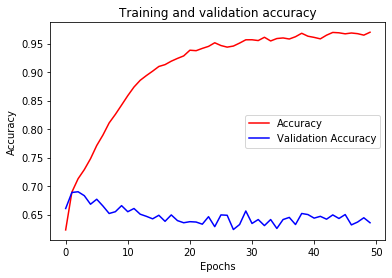

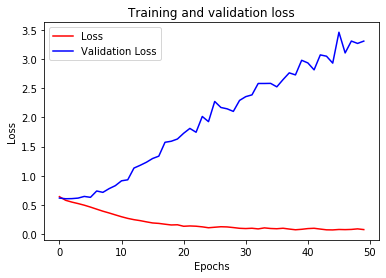

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [0]:
model.save('lstm-1-layer-24.h5')